In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import sys
sys.path.insert(0,'../GSHEWaveform/')

import forecast as fc

from importlib import reload

## GW catalogue & SNR

In [2]:
gwtc=pd.read_csv('/home/miguel/code/notebooks/gw_data/GWTC.csv')

In [3]:
# print(gwtc)

(array([ 3., 15., 16., 18., 11., 10.,  4.,  3.,  4.,  1.,  3.,  0.,  0.,
         0.,  3.,  1.,  0.,  0.,  0.,  1.]),
 array([ 6.  ,  7.35,  8.7 , 10.05, 11.4 , 12.75, 14.1 , 15.45, 16.8 ,
        18.15, 19.5 , 20.85, 22.2 , 23.55, 24.9 , 26.25, 27.6 , 28.95,
        30.3 , 31.65, 33.  ]),
 <BarContainer object of 20 artists>)

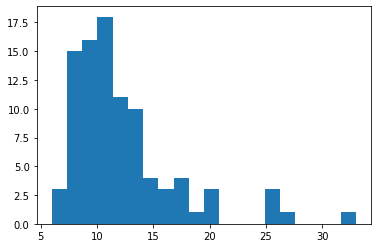

In [4]:
#look at the SNR distribution
plt.hist(gwtc['network_matched_filter_snr'],20)

(array([11., 12., 16., 29., 11.,  2.,  5.,  0.,  2.,  2.]),
 array([  1.46 ,  11.864,  22.268,  32.672,  43.076,  53.48 ,  63.884,
         74.288,  84.692,  95.096, 105.5  ]),
 <BarContainer object of 10 artists>)

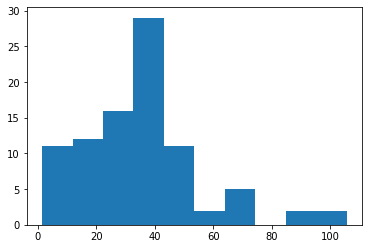

In [5]:
plt.hist(gwtc['mass_1_source'])

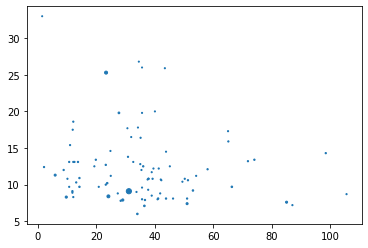

In [6]:
plt.scatter(gwtc['mass_1_source'],gwtc['network_matched_filter_snr'],s=gwtc['mass_1_source']/gwtc['mass_2_source'])

In [7]:
dat = (gwtc['mass_1_source'][np.isfinite(gwtc['mass_1_source'])])
np.median(dat), np.mean(dat)

(35.25, 35.05177777777778)

## Import $\Upsilon_{\rm obs}(\beta_{\rm min},\mu_{\rm min})$

In [8]:
#Load the data (computed in )
data_dict = np.load("../data/Ups_obs_mu_min.npy", allow_pickle=True).item()
betalims = data_dict["betalims"]
mu_min_arr = data_dict["mu_min_arr"]
ups_obs_arr = data_dict["ups_obs_arr"]

<ipython-input-9-b4893696458e>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


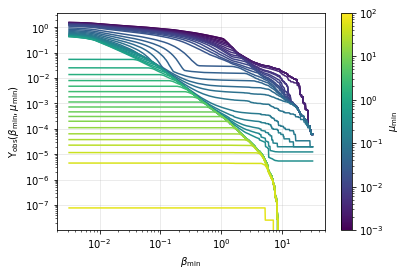

In [9]:
import matplotlib.colors as colors

ups_obs_arr = np.array(ups_obs_arr)


fig, ax = plt.subplots()
lines = []

mu_min_norm = colors.LogNorm(vmin=min(mu_min_arr), vmax=max(mu_min_arr))
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=mu_min_norm, cmap='viridis'), ax=ax)
cmap = plt.cm.get_cmap('viridis')

for i, mu_min in enumerate(mu_min_arr):
    line, = ax.loglog(betalims, ups_obs_arr[i, :], c=cmap(mu_min_norm(mu_min)))
    lines.append(line)

cbar.set_label(r'$\mu_{\rm min}$')



ax.set_ylabel(r"$\Upsilon_{\rm obs}(\beta_{\rm min},\mu_{\rm min})$")
ax.set_xlabel(r"$\beta_{\rm min}$")

ax.grid(alpha=0.3)
plt.show()

fig.tight_layout()
# if tosave:
#     fig.savefig(join(fout, "ups_obs_magnif_many.pdf"), dpi=450)

<ipython-input-10-aec22ed4f08b>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


Text(0.5, 0, '$\\beta_{\\rm min}$')

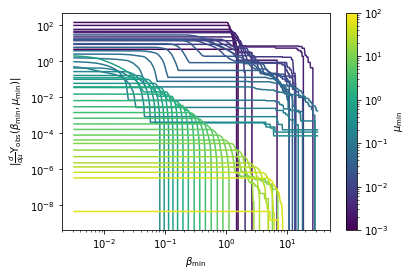

In [10]:
reload(fc)

#fill an array
dups_obs_dmu = fc.d_ups_obs_dmu(fc.ups_obs_arr,fc.mu_min_arr)

fig, ax = plt.subplots()
lines = []

mu_min_norm = colors.LogNorm(vmin=min(mu_min_arr), vmax=max(mu_min_arr))
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=mu_min_norm, cmap='viridis'), ax=ax)
cmap = plt.cm.get_cmap('viridis')

for i in range(0,len(mu_min_arr)-1):

    mu_min = mu_min_arr[i]
    line, = ax.loglog(betalims, np.abs(dups_obs_dmu[i,:]), c=cmap(mu_min_norm(mu_min)))
    lines.append(line)

cbar.set_label(r'$\mu_{\rm min}$')

ax.set_ylabel(r"$|\frac{d}{d\mu} \Upsilon_{\rm obs}(\beta_{\rm min},\mu_{\rm min})|$")
ax.set_xlabel(r"$\beta_{\rm min}$")

Generalizing the previous expression we have the following detection probability

$$p_i = f(M,r_{\rm src}) \int d\mu \mu^{3/2} \frac{d\Upsilon_{\rm Obs}}{d\mu}(\beta^i_{\rm ex}(M),r_{\rm src},\mu) = \frac{3}{2}f(M,r_{\rm src}) \int d\mu \mu^{1/2} \Upsilon_{\rm Obs}(\beta^i_{\rm ex}(M),r_{\rm src},\mu)$$

Notes:
* $\mu^{3/2}$ is a volume prior: very demagnified events are detectable, but they'd have to be very close to us (at observed SNR)
* the second expression follows by partial integration, so we can work with $\Upsilon_{\rm Obs}$
* we're allowing for arbitrary many loops (this can be reduced)
* we're considering the images individually

Going forward:
* figure out scaling with $r_{\rm src}$
* given $r_{\rm src},M$, interpolate on $\beta(M), r_{\rm src}$ for all the available $\mu$'s. Then do the magnification integral through array

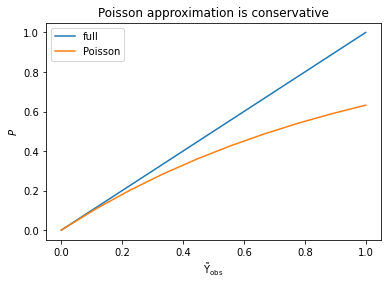

In [11]:
x = np.linspace(0,1,10)
plt.plot(x,x,label='full')
plt.plot(x,1-np.exp(-x),label='Poisson')
plt.title('Poisson approximation is conservative')
plt.xlabel(r'$\tilde \Upsilon_{\rm obs}$')
plt.ylabel(r'$P$')
plt.legend()

## Mismatch

We will use a simple criterion for detectability when $\mathcal{M}\cdot {\rm SNR}^2>1$ to estimate the number of detectable signals.

If we use our scaling as $\beta^2$ (for small $\beta$) then we can obtain the limit $\beta< \frac{\beta_0}{ \sqrt{\mathcal{M_0}} {\rm SNR}}$

/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:115: RuntimeWarning: divide by zero encountered in divide
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))
/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:115: RuntimeWarning: invalid value encountered in divide
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))
/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:115: RuntimeWarning: invalid value encountered in exp
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))
/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:115: RuntimeWarning: divide by zero encountered in divide
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))
/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:115: RuntimeWarning: invalid value encountered in divide
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))
/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:115: RuntimeWarning: invalid value encountered in exp
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))


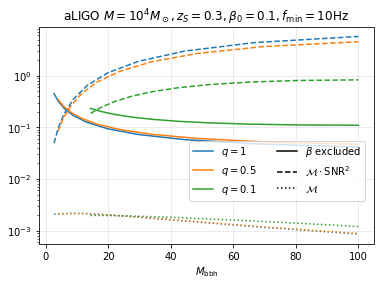

In [12]:
m_min = 1.3
bt_fid = 0.1
zS = 0.3
for i,q in enumerate([1,0.5,0.1]):
    Mbbh = np.geomspace(m_min*(1+1/q),100,10)
    dat = [fc.mismatch_gshe(M,q=q,fmin=10,bt_fid=bt_fid,z=zS,psd_fun=fc.psd_ligo) for M in Mbbh]
    dat = np.array(dat)
    plt.semilogy(Mbbh,dat[:,0]*dat[:,1]**2,'--',c='C%i'%i)
    plt.plot(Mbbh,dat[:,0],':',c='C%i'%i)
    plt.plot(Mbbh,bt_fid/np.sqrt(dat[:,0])/dat[:,1],'-',label='$q=%g$'%q,c='C%i'%i)
    
plt.plot([],'k-',label=r'$\beta$ excluded')
plt.plot([],'k--',label=r'$\mathcal{M}\cdot{\rm SNR}^2$')
plt.plot([],'k:',label=r'$\mathcal{M}$')
    
plt.legend(ncol=2,loc=(0.45,0.2))
plt.xlabel(r"$M_{\rm bbh}$")
plt.title(r"aLIGO $M=10^4M_\odot, z_S=%g,\beta_0 =%g,f_{\rm min}=10$Hz"%(zS,bt_fid))
plt.grid(alpha=0.3)

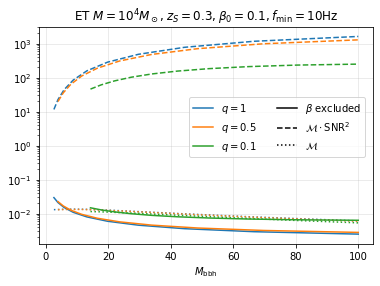

In [13]:
m_min = 1.3
bt_fid = 0.1
zS = 0.3
for i,q in enumerate([1,0.5,0.1]):
    Mbbh = np.geomspace(m_min*(1+1/q),100,10)
    dat = [fc.mismatch_gshe(M,q=q,fmin=10,bt_fid=bt_fid,z=zS,psd_fun=fc.psd_et) for M in Mbbh]
    dat = np.array(dat)
    plt.semilogy(Mbbh,dat[:,0]*dat[:,1]**2,'--',c='C%i'%i)
    plt.plot(Mbbh,dat[:,0],':',c='C%i'%i)
    plt.plot(Mbbh,bt_fid/np.sqrt(dat[:,0])/dat[:,1],'-',label='$q=%g$'%q,c='C%i'%i)
    
plt.plot([],'k-',label=r'$\beta$ excluded')
plt.plot([],'k--',label=r'$\mathcal{M}\cdot{\rm SNR}^2$')
plt.plot([],'k:',label=r'$\mathcal{M}$')
    
plt.legend(ncol=2,loc=(0.45,0.4))
plt.xlabel(r"$M_{\rm bbh}$")
plt.title(r"ET $M=10^4M_\odot, z_S=%g,\beta_0 =%g,f_{\rm min}=10$Hz"%(zS,bt_fid))
plt.grid(alpha=0.3)

## Number of sources

Using https://github.com/hsinyuc/distancetool

Output--
Range (Mpc);
Redshift at which the detector can detect 50% of the uniformly distributed sources;
Redshift at which the detector can detect 10% of the uniformly distributed sources;
Redshift of the horizon;
Constant comoving time volume (Gpc^3);
Redshift within which 50% of the detected sources lie;
Redshift within which 90% of the detected sources lie;
Redshift within which 50% of the detected sources lie, the source distribution follows a star formation rate;
Redshift within which 90% of the detected sources lie, the source distribution follows a star formation rate;
Average redshift of the detected sources;
Average redshift of the detected sources, the source distribution follows a star formation rate.



The quantity is the comoving time volume. However, it is more convenient to include a function x(D) that accounts for the fraction of detected events at distance D

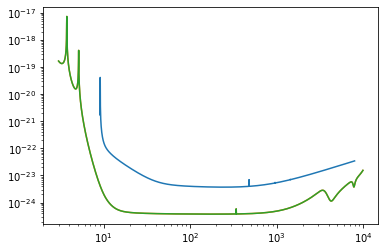

In [14]:
reload(fc)
for f in [fc.aligo_file,fc.CE1_file,fc.CE2_file]:
    d = np.genfromtxt(f)
    plt.loglog(d[:,0],d[:,1])

In [15]:
plt.plot(out['z_array'],out['compensate_det_frac_array'],label='det fraction')
plt.semilogy(out['z_array'],out['unit_volume_arrayMpc3']/1e9,label='d volume [1/Gpc]')
plt.grid(alpha=0.3)
plt.ylim(1e-4,)
plt.xlabel('z')
plt.legend()

NameError: name 'out' is not defined

In [ ]:
V = cosmo.comoving_volume(out['z_array'])/u.Mpc**3
dV = np.gradient(V,out['z_array'])

plt.semilogy(out['z_array'],out['unit_volume_arrayMpc3'],label='d volume')

volume_det = (4*np.pi*u.sr*cosmo.differential_comoving_volume(out['z_array'])/(1+out['z_array'])*out['compensate_det_frac_array']/u.Mpc**3).decompose()

plt.semilogy(out['z_array'],volume_det)
plt.semilogy(out['z_array'],dV/(1+out['z_array'])*out['compensate_det_frac_array'])
plt.grid(alpha=0.3)

print(np.average(volume_det/out['unit_volume_arrayMpc3']*1e9),100*np.pi)

plt.title('differential volume not matching! ')

In [ ]:
z = np.geomspace(0.1,10,50)

V1 = cosmo.comoving_volume(z)/u.Mpc
V2 = gwhor.de.comoving_volume_de(z,**gwhor.cosmo)

#plt.loglog(z,V1); plt.loglog(z,V2)

plt.plot(z,V1/V2)
plt.title('but comoving volumes agree!')


In [ ]:
#trying to debug

m1 = 30
m2 = 30

snr_th = 8

fmin=10.
fref=10.
df=1.
maximum_freq = 1e3
approx = gwhor.ls.IMRPhenomD



n_zstep=400

asdfile = '/home/miguel/code/utils/distancetool/data/aLIGO/Advanced_LIGO_Design.txt'


z_hor = fc.guess_z_horizon(m1,m2, asdfile, snr_th = 8,fmin=10.,fref=10.,df=1.,maximum_freq = 1e3,approx = gwhor.ls.IMRPhenomD)

input_freq,strain=np.loadtxt(asdfile,unpack=True,usecols=[0,1])
print(min(input_freq))
minimum_freq=np.maximum(min(input_freq),fmin)
maximum_freq=np.minimum(max(input_freq),5000.)
interpolate_psd = interp1d(input_freq, strain**2)


z,dz=np.linspace(z_hor,0,n_zstep,endpoint=False,retstep=True)
dz=abs(dz)
unit_volume=np.zeros(np.size(z)); compensate_detect_frac=np.zeros(np.size(z))
for i in range(0,np.size(z)):	
    hplus_tilda,hcross_tilda,freqs = gwhor.get_htildas((1.+z[i])*m1,(1.+z[i])*m2, gwhor.de.luminosity_distance_de(z[i],**gwhor.cosmo) ,fmin=fmin,fref=fref,df=df,approx=approx)
    fsel = np.logical_and(freqs>minimum_freq,freqs<maximum_freq)
    psd_interp = interpolate_psd(freqs[fsel])  
    optsnr_z= gwhor.compute_horizonSNR(hplus_tilda,psd_interp,fsel,df)
    w=snr_th/optsnr_z
    compensate_detect_frac[i]=fc.prob_detect(w)		
    unit_volume[i]=(gwhor.de.comoving_volume_de(z[i]+dz/2.,**gwhor.cosmo)-gwhor.de.comoving_volume_de(z[i]-dz/2.,**gwhor.cosmo))/(1.+z[i])*fc.prob_detect(w)

### Compute fraction of events at a given distance

$w = {\rm SNR}_{\rm opt}/{\rm SNR}_{\rm thr}$, probability of detection given by $P(w)$

In [ ]:
plt.plot(fc.w_sample,fc.P_sample)
# plt.plot(fc.w_sample,fc.dP_sample)

In [ ]:
z_array = np.geomspace(1e-2,50,50)
SNR_opt_array = fc.SNR_opt(z_array,60,fc.aligo_file,q=1)

In [ ]:
plt.loglog(z_array,SNR_opt_array,label='SNR_opt, mu = 1')
plt.loglog(z_array,P_detect(8/SNR_opt_array))

for mu,ls in zip([0.1,1,10],[':','-','--']):
    plt.loglog(z_array,P_detect(8/SNR_opt_array/np.sqrt(mu)),ls,c='k',label='P_det, mu=%g'%mu)

plt.ylim(1e-3,)
plt.grid(alpha=0.3)
plt.xlabel('z')
plt.legend()

## Number of detectable signals

$$ dN = f_{\rm C}(M,r_{\rm src})\int dz_s \frac{dV_z}{dz}(z_s)\mathcal{R}(z_s) \int d\mu P_{\rm det}\left(\frac{\rho_{\rm th}}{\sqrt{\mu}\rho_{\rm opt}(z_s)}\right) \frac{d P_{GSHE}}{d\mu}(\mu,\beta_{\rm min}(z_s,\mu))$$

with $\beta_{\rm min} = \frac{\beta_{0}}{\mathcal{M}_0}\frac{1}{\sqrt{\mu}\rho}$

* **role of SNR below optimal on beta_min**
* **total number of events, magnification**

We will assume a constant rate $\mathcal{R}(z)=\mathcal{R}_0$ and quote the effective survey volume $V_{\rm GSHE}= \frac{N}{\mathcal{R}_0}$, for $\mathcal{R}$ constant

**SNR for $\beta_{\rm min}$**

In [16]:
#double integrals from https://stackoverflow.com/questions/20668689/integrating-2d-samples-on-a-rectangular-grid-using-scipy
from scipy.integrate import simps
import numpy as np
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 30)
z = np.cos(x[:,None])**4 + np.sin(y)**2
simps(simps(z, y), x)

0.8513409974325955

In [17]:
%%timeit
fc.beta_min(60,z=10)

32.2 ms ± 3.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
for M_fid in [1e4,1e5]:
    print(fc.mismatch_gshe(60, q,M_fid=M_fid), fc.beta_min(60,0.5,M_fid=M_fid))

[0.0016025004791563324, 21.25587344982419] 0.08584120755549743
[1.6061005905565473e-05, 21.25587344982419] 0.8573120673485289


### Systematic plotting

In [19]:
cases = {'L-8-4': ['LIGO', 8, 60, 1e4, 30],
         'L-8-4-20': ['LIGO', 8, 20, 1e4, 30],
         'L-8-4-3': ['LIGO', 8, 3, 1e4, 30],
         'L-8-5': ['LIGO', 8, 60, 1e5, 30],
         'L-8-6': ['LIGO', 8, 60, 1e6, 30],
         'L-1-4': ['LIGO', 1, 60, 1e4, 30],
         'L-1-5': ['LIGO', 1, 60, 1e5, 30],
         'L-1-6': ['LIGO', 1, 60, 1e6, 30],
         'C-8-4': ['CE', 8, 60, 1e4, 30],
         'C-8-4-20': ['CE', 8, 20, 1e4, 30],
         'C-8-4-3': ['CE', 8, 3, 1e4, 30],
         'C-8-5': ['CE', 8, 60, 1e5, 30],
         'C-8-6': ['CE', 8, 60, 1e6, 30],
         'C-1-4': ['CE', 1, 60, 1e4, 30],
         'C-1-5': ['CE', 1, 60, 1e5, 30],
         'C-1-6': ['CE', 1, 60, 1e6, 30],
        }

GSHE_results = {}

for k in cases.keys():
    
    experiment, snr_th, M_bbh, M_fid, R0 = cases[k]
    psd, file = [fc.CE_psd, fc.CE1_file] if experiment == 'CE' else [fc.psd_ligo, fc.aligo_file]
    zs = np.geomspace(0.01,50,30) if experiment == 'CE' else np.geomspace(0.01,10,30)
    
    output = fc.GSHE_rates(M_bbh,psd, file,return_arrays=True,snr_th=snr_th,M_fid=M_fid,R0=R0,zs=zs)
    GSHE_results[k] = output
    
    var = output['integrand']
    mus= output['mu_vals']
    zs = output['z_vals']
    minimum = max(var[var>0].min(),1e-5*var.max())
    norm=colors.LogNorm(vmin=minimum, vmax=var.max())
    c = plt.pcolor(mus,zs,var,norm=norm,rasterized=True)
    c2 = plt.contour(mus,zs,var,[1/R0])
    plt.colorbar(c,label='GSHE volume [Gpc$^3$]')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$z$')

    plt.title(r'%s SNR>%g, $M_{\rm fid}=%g, M_{\rm BBH}=%g$'%(experiment,snr_th,M_fid,M_bbh))
    plt.grid(alpha=0.3)
    plt.savefig('../plots/GSHE_volume_%s_SNRth=%g_M_fid=%g_M_bbh=%g.png'%(experiment,snr_th,M_fid,M_bbh))
    plt.savefig('../plots/GSHE_volume_%s_SNRth=%g_M_fid=%g_M_bbh=%g.pdf'%(experiment,snr_th,M_fid,M_bbh),bbox_inches='tight')
    plt.close()

/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:115: RuntimeWarning: divide by zero encountered in divide
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))
/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:115: RuntimeWarning: invalid value encountered in divide
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))
/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:115: RuntimeWarning: invalid value encountered in exp
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))
/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:115: RuntimeWarning: divide by zero encountered in divide
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))
/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:115: RuntimeWarning: invalid value encountered in divide
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))
/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:115: RuntimeWarning: invalid value encountered in exp
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))
/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.

In [ ]:
print(GSHE_results['L-8-4'].keys())
print(cases['L-8-4'])

In [ ]:
def latex_exp(x, exp_min = (0,0),ndec=2):
    if x == 0:
        return '%g'%x
    expon = np.log10(x)
    expon = np.floor(expon) if expon>0 else np.ceil(expon)
    if expon>=exp_min[0] and expon<=exp_min[1]:
        ndec = max(ndec,exp_min[1] if expon>0 else -exp_min[0])
#         print('*',x)
        form = '%.'+('%i'%ndec)+'f'
#         print(form)
#         form = '%.'+form+'g'
        return form%x
    mant = x/10**expon
    if mant ==1:
#         print('.',x)
        return '10^{%i}'%(expon)
    else:
        form = '%.'+('%i'%ndec)+'f'
        return (form+'\cdot 10^{%i}')%(mant,expon)

latex_exp(1e2,exp_min=(-2,4)), latex_exp(0), latex_exp(1.2), latex_exp(1e-3,exp_min=(-3,4)),latex_exp(1.2345e-8)

In [ ]:
print(output.keys())

In [ ]:
# 
#table

print(r'Exp. & ${\rm SNR}_{\rm th}$ & $M_{\rm BBH}\, [M_\odot]$ & $M\, [M_\odot]$ [name!] & $V_{\rm GSHE}\, [{\rm Gpc}^3]$ & $\dot N_{\rm det} [{\rm yr}^{-1}]$ & $\dot N_{\rm GSHE} [{\rm yr}^{-1}]$\\')
print('\hline')
for n,k in enumerate(GSHE_results.keys()):
    pars = cases[k]
    out = GSHE_results[k]
    print(pars[0], '& $%s$'%pars[1],  '& $%s$'%pars[2], '& $%s$'%latex_exp(pars[3]), '&  $%s$'%latex_exp(out['GSHE_volume [Gpc^3]']), ' & $%s$'%latex_exp(out['rate detection [1/yr]']), '& $%s$'%latex_exp(out['rate GSHE [1/yr]']),r'\\')
    if n in [7]: #[2,7,10]:
        print(r'\hline')
        
print(r'\hline')

### A-LIGO

Result is in Gpc^3/y, need to multiply by R0!

Assumes M=1e4 M_sun, R_src = 5r_s, f = 1, M_tot = 60

In [24]:
from matplotlib import colors

In [80]:
reload(fc)
snr_th = 8
M_bbh = 60
M_fid = 1e4
R0 = 30
experiment='LIGO'

ligo_out = fc.GSHE_rates(M_bbh,fc.psd_ligo, fc.aligo_file,return_arrays=True,snr_th=snr_th,M_fid=M_fid,R0=R0)

/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:115: RuntimeWarning: divide by zero encountered in divide
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))
/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:115: RuntimeWarning: invalid value encountered in divide
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))
/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:115: RuntimeWarning: invalid value encountered in exp
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))


In [81]:
out = ligo_out
print('aLIGO rates: total %g, GSHE %g [1/yr]'%(out['rate detection [1/yr]'], out['rate GSHE [1/yr]']))

aLIGO rates: total 258.542, GSHE 32.5702 [1/yr]


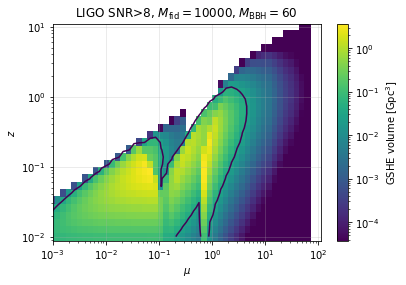

In [82]:
output = ligo_out
var = output['integrand']
mus= output['mu_vals']
zs = output['z_vals']
minimum = max(var[var>0].min(),1e-5*var.max())
norm=colors.LogNorm(vmin=minimum, vmax=var.max())

c = plt.pcolor(mus,zs,var,norm=norm,rasterized=True)
c2 = plt.contour(mus,zs,var,[1/R0])
plt.colorbar(c,label='GSHE volume [Gpc$^3$]')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$z$')

plt.title(r'%s SNR>%g, $M_{\rm fid}=%g, M_{\rm BBH}=%g$'%(experiment,snr_th,M_fid,M_bbh))
plt.grid(alpha=0.3)
plt.savefig('../plots/GSHE_volume_%s_SNRth=%g_M_fid=%g_M_bbh=%g.png'%(experiment,snr_th,M_fid,M_bbh))

Text(0.5, 1.0, 'aLIGO')

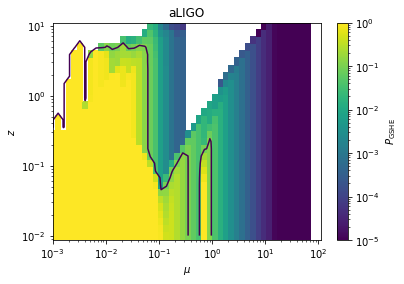

In [28]:
output = ligo_out
var = output['P_GSHE']
mus= output['mu_vals']
zs = output['z_vals']
minimum = max(var[var>0].min(),1e-5*var.max())
norm=colors.LogNorm(vmin=minimum, vmax=var.max())

c = plt.pcolor(mus,zs,var,norm=norm)
c2 = plt.contour(mus,zs,var,[0.1])
plt.colorbar(c,label=r'$P_{\rm GSHE}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$z$')
plt.title('aLIGO')

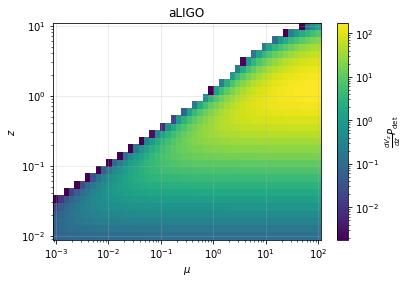

In [29]:
output = ligo_out
var = output['dVzdz']*output['p_det']
mus= output['mu_vals']
zs = output['z_vals']
minimum = max(var[var>0].min(),1e-5*var.max())
norm=colors.LogNorm(vmin=minimum, vmax=var.max())

c = plt.pcolor(mus,zs,var,norm=norm)
# c2 = plt.contour(mus,zs,integrand,[1])
plt.colorbar(c,label=r'$\frac{dV_z}{dz}P_{\rm det}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$z$')
plt.title('aLIGO')
plt.grid(alpha=0.3)

In [30]:
for x in [p_det,btmin,P_GSHE,dVzdz]:
    print(len(x[:,0]),len(x[0,:]))

NameError: name 'p_det' is not defined

### CE

In [69]:
reload(fc)
snr_th = 8
M_bbh = 60
M_fid = 1e4
zs = np.geomspace(0.01,50,30)
R0=R0
experiment='CE'

CE_out = fc.GSHE_rates(M_bbh,fc.CE_psd, fc.CE1_file,return_arrays=True,snr_th=snr_th,M_fid=M_fid,zs=zs,R0=R0)

In [70]:
out = CE_out
print('CE rates: total %g, GSHE %g [1/yr]'%(out['rate detection [1/yr]'], out['rate GSHE [1/yr]']))

CE rates: total 22324.8, GSHE 3554.38 [1/yr]


In [71]:
out = CE_out
print('CE rates: total %g, GSHE %g [1/yr]'%(out['rate detection [1/yr]'], out['rate GSHE [1/yr]']))

CE rates: total 22324.8, GSHE 3554.38 [1/yr]


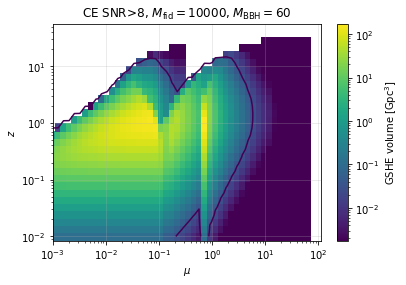

In [78]:
output = CE_out
var = output['integrand']
mus= output['mu_vals']
zs = output['z_vals']
minimum = max(var[var>0].min(),1e-5*var.max())
norm=colors.LogNorm(vmin=minimum, vmax=var.max())

c = plt.pcolor(mus,zs,var,norm=norm,rasterized=True)
c2 = plt.contour(mus,zs,var,[1/R0])
plt.colorbar(c,label='GSHE volume [Gpc$^3$]')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$z$')
plt.title(r'%s SNR>%g, $M_{\rm fid}=%g, M_{\rm BBH}=%g$'%(experiment,snr_th,M_fid,M_bbh))
plt.grid(alpha=0.3)
plt.savefig('../plots/GSHE_volume_%s_SNRth=%g_M_fid=%g_M_bbh=%g.png'%(experiment,snr_th,M_fid,M_bbh))

Text(0.5, 1.0, 'CE')

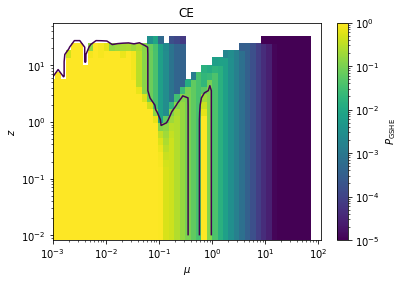

In [75]:
output = CE_out
var = output['P_GSHE']
mus= output['mu_vals']
zs = output['z_vals']
minimum = max(var[var>0].min(),1e-5*var.max())
norm=colors.LogNorm(vmin=minimum, vmax=var.max())

c = plt.pcolor(mus,zs,var,norm=norm)
c2 = plt.contour(mus,zs,var,[0.1])
plt.colorbar(c,label=r'$P_{\rm GSHE}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$z$')
plt.title('CE')

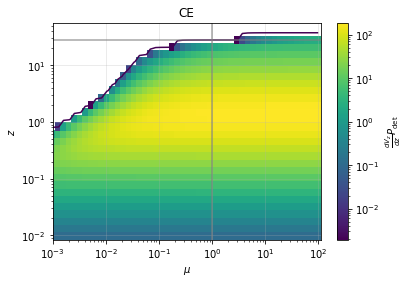

In [76]:
output = CE_out
var = output['dVzdz']*output['p_det']
mus= output['mu_vals']
zs = output['z_vals']
minimum = max(var[var>0].min(),1e-5*var.max())
norm=colors.LogNorm(vmin=minimum, vmax=var.max())

c = plt.pcolor(mus,zs,var,norm=norm)
c2 = plt.contour(mus,zs,output['p_det'],[0.001])
plt.colorbar(c,label=r'$\frac{dV_z}{dz}P_{\rm det}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$z$')
plt.title('CE')
plt.grid(alpha=0.3)
plt.axvline(1,color='gray',alpha=0.7)
plt.axhline(28,color='gray',alpha=0.7)

In [77]:
#Consistent with CE horizon, figure 2 in Chen+17
#seems consistent with 3G science book, where z(60Msun) ~ 30 at SNR=3, but for a detector network
cosmo.comoving_distance(28)

NameError: name 'cosmo' is not defined

In [38]:
zs = np.geomspace(0.1,1000)
plt.loglog(zs,cosmo.differential_comoving_volume(zs))
plt.loglog(zs,cosmo.luminosity_distance(zs))

NameError: name 'cosmo' is not defined